In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/gdrive')
!ls /gdrive/My\ Drive/dacon/security_detect/train-dataset/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
train1.csv  train2.csv	train3.csv


In [5]:
!pip install /gdrive/My\ Drive/dacon/eTaPR-1.12-py3-none-any.whl
!pip install opencv-python

Processing /gdrive/My Drive/dacon/eTaPR-1.12-py3-none-any.whl
eTaPR is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [6]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



from tqdm.notebook import trange
from TaPR_pkg import etapr

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam


print(tf.version.VERSION)
import tensorflow.keras.backend as K

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

gpu()

Found GPU at: /device:GPU:0
2.7.0


<tf.Tensor: shape=(), dtype=float32, numpy=881.45996>

# 데이터 확인



---



In [7]:
TRAIN_DATASET = sorted([x for x in Path('/gdrive/My Drive/dacon/security_detect/train-dataset/').glob("*.csv")])
TRAIN_DATASET

[PosixPath('/gdrive/My Drive/dacon/security_detect/train-dataset/train1.csv'),
 PosixPath('/gdrive/My Drive/dacon/security_detect/train-dataset/train2.csv'),
 PosixPath('/gdrive/My Drive/dacon/security_detect/train-dataset/train3.csv')]

In [8]:
TEST_DATASET = sorted([x for x in Path('/gdrive/My Drive/dacon/security_detect/test-dataset/').glob("*.csv")])
TEST_DATASET

[PosixPath('/gdrive/My Drive/dacon/security_detect/test-dataset/test1.csv'),
 PosixPath('/gdrive/My Drive/dacon/security_detect/test-dataset/test2.csv'),
 PosixPath('/gdrive/My Drive/dacon/security_detect/test-dataset/test3.csv'),
 PosixPath('/gdrive/My Drive/dacon/security_detect/test-dataset/test4.csv')]

In [9]:
VALIDATION_DATASET = sorted([x for x in Path("/gdrive/My Drive/dacon/security_detect/validation-dataset/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('/gdrive/My Drive/dacon/security_detect/validation-dataset/validation.csv')]

In [10]:
def dataframe_from_csv(target):
    ''' 데이터 불러오기 '''
    return pd.read_csv(target, error_bad_lines=False).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    ''' 데이터 합치기 '''
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [11]:
# 트레인 데이터 불러오기 + 합치기
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)

In [12]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET # time 컬럼을 제외한 데이터 셋

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

# 전처리

### 노말라이제이션

In [13]:
''' this is for normalization'''

TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()
# TAG_MIN.to_csv('/gdrive/My Drive/dacon/security_detect/TAG_MIN.csv')
# TAG_MAX.to_csv('/gdrive/My Drive/dacon/security_detect/TAG_MAX.csv')

# TAG_MIN = pd.read_csv('/gdrive/My Drive/dacon/security_detect/TAG_MIN.csv')
# TAG_MAX = pd.read_csv('/gdrive/My Drive/dacon/security_detect/TAG_MAX.csv')

In [14]:
''' 노말라이즈 '''
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [15]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [16]:
'''지수평활법 ewm'''
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean() # 노말라이즈된 트레이닝 셋

In [17]:
def boundary_check(df):
  ''' 1보다큰게있는지, 0보다 작은게 있는지, na가 있는지 '''
  x = np.array(df, dtype=np.float32)
  return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

# 시퀀스별로 나누자



In [18]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90



def prepare(timestamps, df, stride = 1, attacks = None):
  ''' 89 개씩 자르는 전처리 '''
  X = []
  Y = []
  att = []
  
  ts = np.array(timestamps)
  tag_values = np.array(df, dtype=np.float32)
  valid_idxs = []

  ''' valid 한것만 전처리 '''
  for L in trange(len(ts) - WINDOW_GIVEN):
    R = L + WINDOW_GIVEN
    if dateutil.parser.parse(ts[R]) - dateutil.parser.parse(ts[L]) == timedelta(seconds = WINDOW_SIZE - 1):
      valid_idxs.append(L)

  ''' stride '''
  stride_idx = np.array(valid_idxs, dtype = np.int32)[::stride]

  ''' 시퀀스 스트라이드 1로 '''
  for t in trange(len(valid_idxs) - WINDOW_SIZE):
    if np.abs(valid_idxs[t] - valid_idxs[t+1]) == 1:
      x = tag_values[valid_idxs[t]:valid_idxs[t+WINDOW_GIVEN]]
      X.append(x)
      y = tag_values[valid_idxs[t]+WINDOW_SIZE]
      Y.append(y)
      att.append(valid_idxs[WINDOW_SIZE])

  stride_idxs = np.array(valid_idxs, dtype=np.int32)[::stride]

  return X, Y, valid_idxs, att




X, Y, valid_idxs, att = prepare(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)

  0%|          | 0/921514 [00:00<?, ?it/s]

  0%|          | 0/921246 [00:00<?, ?it/s]

In [19]:
stride = 10
X = []
Y = []

ts = np.array(TRAIN_DF_RAW[TIMESTAMP_FIELD])
tag_values = np.array(TRAIN_DF, dtype=np.float32)

for t in trange(0, len(valid_idxs) - WINDOW_SIZE, stride):
  last = valid_idxs[t + WINDOW_SIZE] # 90
  start = valid_idxs[t] # 0
  end = valid_idxs[t+WINDOW_GIVEN] # 89

  if np.abs(valid_idxs[t] - valid_idxs[t+WINDOW_GIVEN]) == 89:
    x = tag_values[start:end]
    X.append(x)
    y = tag_values[last]
    Y.append(y)

  0%|          | 0/92125 [00:00<?, ?it/s]

In [20]:
X1 = np.array(X)
X1[1].shape

(89, 79)

In [21]:
X1 = np.array(X)
for i in trange(0, 92107):
  if X1[i].shape[0] !=  88:
    print(i)
    break
  elif X1[i].shape[1] != 79:
    print(i)
    break

  0%|          | 0/92107 [00:00<?, ?it/s]

0


In [22]:
X1.shape

(92107, 89, 79)

In [23]:
Y1 = np.array([Y])
Y1.shape

(1, 92107, 79)

In [24]:
Y1[0].shape

(92107, 79)

# 모델

In [ ]:
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())

In [36]:
X1.shape

(92107, 89, 79)

In [37]:
Y1.shape

(1, 92107, 79)

In [ ]:
X1.shape[1:]

(89, 79)

In [38]:
from tensorflow import keras

input_ = tf.keras.Input(shape = (89,79))
rnn = keras.layers.Bidirectional(keras.layers.LSTM(100, return_state=False, return_sequences=False))
x = rnn(input_)
# output = keras.layers.Dense(79, activation = 'relu')(x)
output = Dense(79, activation = 'relu')(x)

model = keras.Model(input_, outputs = output)

model.compile(
    loss = 'MSE',
    optimizer = 'adam'
)

In [39]:
BATCH_SIZE = 512
EPOCHS = 100

print('Training model...')
r = model.fit(
  X1,
  Y1.reshape(92107,-1),
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
)

Training model...
Epoch 1/100
180/180 [==============================] - 20s 83ms/step - loss: 0.0222
Epoch 2/100
180/180 [==============================] - 15s 85ms/step - loss: 0.0087
Epoch 3/100
180/180 [==============================] - 16s 91ms/step - loss: 0.0080
Epoch 4/100
180/180 [==============================] - 16s 88ms/step - loss: 0.0076
Epoch 5/100
180/180 [==============================] - 15s 83ms/step - loss: 0.0074
Epoch 6/100
180/180 [==============================] - 15s 83ms/step - loss: 0.0072
Epoch 7/100
180/180 [==============================] - 15s 84ms/step - loss: 0.0072
Epoch 8/100
180/180 [==============================] - 15s 83ms/step - loss: 0.0071
Epoch 9/100
180/180 [==============================] - 15s 84ms/step - loss: 0.0071
Epoch 10/100
180/180 [==============================] - 15s 84ms/step - loss: 0.0070
Epoch 11/100
180/180 [==============================] - 15s 84ms/step - loss: 0.0070
Epoch 12/100
180/180 [==============================] - 

In [25]:
# 모델 저장
!pip install -q pyyaml h5py

# model.save('/gdrive/My Drive/dacon/security_detect/my_model2')
new_model = tf.keras.models.load_model('/gdrive/My Drive/dacon/security_detect/my_model2')

In [26]:
new_model.summary()

Model: "functional_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 89, 79)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              144000    
 l)                                                              
                                                                 
 dense (Dense)               (None, 79)                15879     
                                                                 
Total params: 159,879
Trainable params: 159,879
Non-trainable params: 0
_________________________________________________________________


# 학습된 모델을 이용한 탐지

In [27]:
''' validation concat '''
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)

In [28]:
''' normalization '''
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [29]:
boundary_check(VALIDATION_DF)
# 함수안에 최대 최소가 있는게 아니라, 글로벌 변수로 최대 최소를 할당했었다.
# np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))
# 1보다 큰게 있고, 0보다 작은게 있고, nan은 없다.
# 공격 데이터셋에서는 확실히 정상 데이터의 최솟값과 최댓값을 벗어나는 값이 나타나고 있습니다.

(True, True, False)

In [30]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


def test_prepare(timestamps, df, raw_df, stride = 1, attacks=None):
  ''' 89 개씩 자르는 전처리 '''
  X = []
  Y = []
  ts_list = []
  att_list = []
  
  
  # ts = np.array(TRAIN_DF_RAW[TIMESTAMP_FIELD])
  # tag_values = np.array(TRAIN_DF, dtype=np.float32)
  ts = np.array(timestamps)
  tag_values = np.array(df, dtype=np.float32)
  valid_idxs = []


  ''' 시퀀스 스트라이드 1로 '''
  for t in trange(len(ts) - WINDOW_SIZE):
      x = tag_values[t:t+WINDOW_GIVEN]
      X.append(x)
      y = tag_values[t+WINDOW_SIZE]
      Y.append(y)

      ts_list.append(ts[t+WINDOW_SIZE])
      if attacks is not None:
        att_list.append(raw_df['attack'][t+WINDOW_SIZE])

  stride_idxs = np.array(valid_idxs, dtype=np.int32)[::stride]

  return np.array(X), np.array(Y), np.array(valid_idxs), np.array(att_list), np.array(ts_list)


In [31]:
valid_X, valid_Y, valid_idxs, attack, ts = test_prepare(VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, VALIDATION_DF_RAW,stride=1, attacks = VALIDATION_DF_RAW['attack'])

print(len(valid_X), len(ts))

  0%|          | 0/43111 [00:00<?, ?it/s]

43111 43111


In [32]:
ts

array(['2020-07-07 15:01:30', '2020-07-07 15:01:31',
       '2020-07-07 15:01:32', ..., '2020-07-08 02:59:58',
       '2020-07-08 02:59:59', '2020-07-08 03:00:00'], dtype='<U19')

In [33]:
# def inference(X, Y, model, batch_size = 512):
#   ts, dist, att = [],[],[]

#   given = X
#   answer = Y
#   guess = model.predict(given)
#   ts.append(np.array)

In [ ]:
# pre_value = new_model.predict(valid_X)
# pre_value

In [ ]:
# abs(pre_value - valid_Y).shape

In [ ]:
# np.mean(abs(pre_value - valid_Y), axis = 1).shape

In [ ]:
# np.mean(abs(pre_value[0]-valid_Y[0]).reshape(1,-1), axis = 1)

In [34]:
def evaluate(X, Y):
  pre_value = new_model.predict(valid_X)
  dist = np.mean(abs(pre_value - Y), axis =1)

  return dist

In [35]:
dist = evaluate(valid_X, valid_Y)

In [36]:
dist

array([0.01538958, 0.01804199, 0.01613906, ..., 0.00738371, 0.00918657,
       0.00858031], dtype=float32)

In [37]:
'''결과를 눈으로 확인하기 위해 그래프를 그려보겠습니다. piece 파라미터는 그래프를 몇 개로 나누어 그릴지를 결정합니다. 세세한 결과를 보고 싶을 경우 숫자를 늘리면 됩니다.'''

def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))  # plt.subplots(nrows=2, ncols=1)
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()


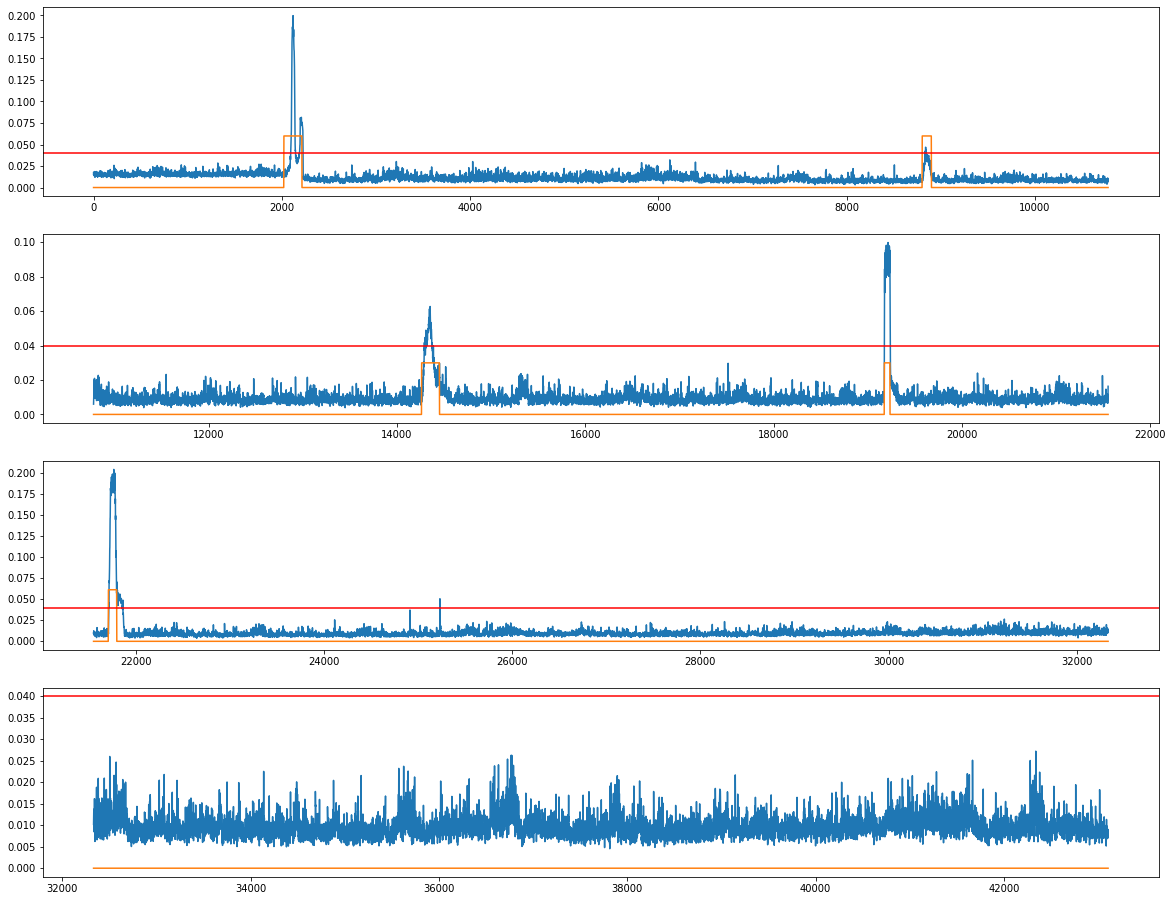

In [38]:
THRESHOLD = 0.04
check_graph(dist, attack, 4, THRESHOLD=THRESHOLD)

In [39]:
'''위의 그래프를 보면 대략 0.04를 기준으로 설정할 수 있을 것으로 보입니다. 
여러 번의 실험을 통해 정밀하게 임계치를 선택하면 더 좋은 결과를 얻을 수 있을 것으로 예상합니다.'''

def put_labels(distance, threshold):
    xs = np.zeros_like(distance) # distance 랑 같은 shape을 갖는 zero matrix를 만듬.
    xs[distance > threshold] = 1 # threshold 보다 높은값에 1을 부여. labeling
    return xs

In [40]:
LABELS = put_labels(dist, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (43111,))

In [41]:
dist.shape

(43111,)

# 정답지(ATTACK_LABELS)도 동일하게 추출합니다. 검증 데이터셋에 공격 여부를 나타내는 필드에는 정상을 0으로 공격을 1로 표기하고 있습니다. 위에 정의한 put_labels 함수를 이용해서 0.5를 기준으로 같은 방식으로 TaPR을 위한 label을 붙여줍니다.

In [42]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (43201,))

In [43]:
def fill_blank(check_ts, labels, total_ts): # check_ts : 타겟들.. 89번째 슬라이스부터 쭉: total_ts보다 88개 적음. //  label : attack labels which has 0 or 1. // total_ts
    def ts_generator():
      
        ''' return total_ts  as time type'''
      
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
      
        ''' return check_ts with labels '''

        for t, label in zip(check_ts, labels): # check_ts : 시간 //  label : attack labels which has 0 or 1.
            yield dateutil.parser.parse(t), label


    g_ts = ts_generator() # yield로 생성되어서 필요할때 부르면됨. yield메모리에 저장됨.
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts) # yield의 다음 값을 호출 // total_ts를 호출
        ts_label, label = next(g_label) # check_ts, label 호출
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [44]:
%%time
FINAL_LABELS = fill_blank(ts, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 14.4 s, sys: 70 ms, total: 14.4 s
Wall time: 16.7 s


In [45]:
FINAL_LABELS.shape

(43201,)

In [46]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.794 (TaP: 0.942, TaR: 0.687)
# of detected anomalies: 4
Detected anomalies: ['1', '3', '4', '5']


# TEST로 평가하기


---



---



In [47]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)

In [48]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [49]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90



def test_(timestamps, df, raw_df, model, stride = 1, attacks=None):
  ''' 89 개씩 자르는 전처리 '''
  X = []
  Y = []
  ts_list = []
  att_list = []
  final = []
  
  # ts = np.array(TRAIN_DF_RAW[TIMESTAMP_FIELD])
  # tag_values = np.array(TRAIN_DF, dtype=np.float32)
  ts = np.array(timestamps)
  tag_values = np.array(df, dtype=np.float32)
  valid_idxs = []
  Y = []

  ''' 시퀀스 스트라이드 1로 '''
  for t in trange(len(ts) - WINDOW_SIZE):
      x = tag_values[t:t+WINDOW_GIVEN].reshape(1,89,79)
      y = tag_values[t+WINDOW_SIZE]

      pre_value = model.predict(x)
      final.append(np.mean(abs(pre_value-y).reshape(1,-1), axis = 1))

      ts_list.append(ts[t+WINDOW_SIZE])
      if attacks is not None:
        att_list.append(raw_df['attack'][t+WINDOW_SIZE])

  stride_idxs = np.array(valid_idxs, dtype=np.int32)[::stride]

  return np.array(X), np.array(Y), np.array(valid_idxs), np.array(att_list), np.array(ts_list), np.array(final)



In [50]:
# valid_X, valid_Y, valid_idxs, attack, ts, final = test_(
#     TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, TEST_DF_RAW, model = new_model
# )

In [51]:
# pd.DataFrame(final).to_csv('/gdrive/My Drive/dacon/security_detect/final.csv')

In [52]:
dist1 = pd.read_csv('/gdrive/My Drive/dacon/security_detect/final.csv')
dist1 = dist1['0']

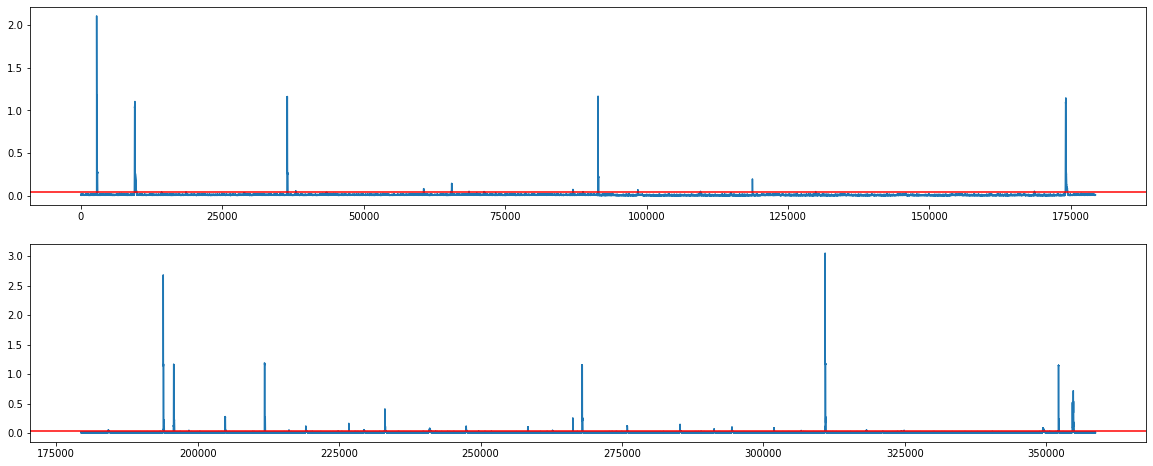

In [53]:
'''결과를 눈으로 확인하기 위해 그래프를 그려보겠습니다. piece 파라미터는 그래프를 몇 개로 나누어 그릴지를 결정합니다. 세세한 결과를 보고 싶을 경우 숫자를 늘리면 됩니다.'''

def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))  # plt.subplots(nrows=2, ncols=1)
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            # axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()
  
THRESHOLD = 0.04
check_graph(dist1, 4, THRESHOLD=THRESHOLD)


In [54]:
'''위의 그래프를 보면 대략 0.04를 기준으로 설정할 수 있을 것으로 보입니다. 
여러 번의 실험을 통해 정밀하게 임계치를 선택하면 더 좋은 결과를 얻을 수 있을 것으로 예상합니다.'''

def put_labels(distance, threshold):
    xs = np.zeros_like(distance) # distance 랑 같은 shape을 갖는 zero matrix를 만듬.
    xs[distance > threshold] = 1 # threshold 보다 높은값에 1을 부여. labeling
    return xs

In [55]:
LABELS1 = put_labels(dist1, THRESHOLD)
LABELS1, LABELS1.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (358714,))

In [56]:
ts1 = TEST_DF_RAW[TIMESTAMP_FIELD][90:]
ts1 = np.array(ts1)

In [57]:
def fill_blank(check_ts, labels, total_ts): # check_ts : 타겟들.. 89번째 슬라이스부터 쭉: total_ts보다 88개 적음. //  label : attack labels which has 0 or 1. // total_ts
    def ts_generator():
      
        ''' return total_ts  as time type'''
      
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
      
        ''' return check_ts with labels '''

        for t, label in zip(check_ts, labels): # check_ts : 시간 //  label : attack labels which has 0 or 1.
            yield dateutil.parser.parse(t), label


    g_ts = ts_generator() # yield로 생성되어서 필요할때 부르면됨. yield메모리에 저장됨.
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts) # yield의 다음 값을 호출 // total_ts를 호출
        ts_label, label = next(g_label) # check_ts, label 호출
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [58]:
%%time
FINAL_LABELS = fill_blank(ts1, LABELS1, np.array(TEST_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 1min 7s, sys: 314 ms, total: 1min 7s
Wall time: 1min 11s


In [59]:
FINAL_LABELS.shape

(358804,)

In [60]:
submission = pd.read_csv('/gdrive/My Drive/dacon/security_detect/sample_submission.csv')
submission.index = submission['time']
submission.loc[TEST_DF_RAW[TIMESTAMP_FIELD],'attack'] = FINAL_LABELS
submission

,time,attack
time,,
2020-07-09 15:00:00,2020-07-09 15:00:00,0
2020-07-09 15:00:01,2020-07-09 15:00:01,0
2020-07-09 15:00:02,2020-07-09 15:00:02,0
2020-07-09 15:00:03,2020-07-09 15:00:03,0
2020-07-09 15:00:04,2020-07-09 15:00:04,0
...,...,...
2020-07-31 12:29:56,2020-07-31 12:29:56,0
2020-07-31 12:29:57,2020-07-31 12:29:57,0
2020-07-31 12:29:58,2020-07-31 12:29:58,0


In [ ]:
submission = pd.read_csv('/gdrive/My Drive/dacon/security_detect/sample_submission.csv')
submission

,time,attack
0,2020-07-09 15:00:00,0
1,2020-07-09 15:00:01,0
2,2020-07-09 15:00:02,0
3,2020-07-09 15:00:03,0
4,2020-07-09 15:00:04,0
...,...,...
358799,2020-07-31 12:29:56,0
358800,2020-07-31 12:29:57,0
358801,2020-07-31 12:29:58,0
358802,2020-07-31 12:29:59,0


In [ ]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

# 테스트 데이터셋 예측

---



---



In [ ]:
TEST_DATASET = sorted([x for x in Path('/gdrive/My Drive/dacon/security_detect/test-dataset/').glob("*.csv")])
TEST_DATASET

order = 0
TEST_DF_RAW = pd.read_csv(TEST_DATASET[order], error_bad_lines=False).rename(columns=lambda x: x.strip())


In [ ]:
# 여기서 트레인으로 노말라이즈 하는게 맞는지, 테스트셋으로 노말라이즈 해야되는거 아닌지...
# TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
# TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [ ]:
normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

KeyError: ignored

In [ ]:
VALID_COLUMNS_IN_TRAIN_DATASET = TEST_DF_RAW.columns.drop([TIMESTAMP_FIELD])
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

KeyError: ignored

In [ ]:
boundary_check(TEST_DF)

(True, True, False)

In [ ]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90



def test_prepare(timestamps, df, raw_df, stride = 1, attacks=None):
  ''' 89 개씩 자르는 전처리 '''
  X = []
  Y = []
  ts_list = []
  att_list = []
  
  # ts = np.array(TRAIN_DF_RAW[TIMESTAMP_FIELD])
  # tag_values = np.array(TRAIN_DF, dtype=np.float32)
  ts = np.array(timestamps)
  tag_values = np.array(df, dtype=np.float32)
  valid_idxs = []


  ''' 시퀀스 스트라이드 1로 '''
  for t in trange(len(ts) - WINDOW_SIZE):
      x = tag_values[t:t+WINDOW_GIVEN]
      X.append(x)
      y = tag_values[t+WINDOW_SIZE]
      Y.append(y)

      ts_list.append(ts[t+WINDOW_SIZE])
      if attacks is not None:
        att_list.append(raw_df['attack'][t+WINDOW_SIZE])

  stride_idxs = np.array(valid_idxs, dtype=np.int32)[::stride]

  return np.array(X), np.array(Y), np.array(valid_idxs), np.array(att_list), np.array(ts_list)



In [ ]:
valid_X, valid_Y, valid_idxs, attack, ts = test_prepare(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, TEST_DF_RAW
)

# inference 함수로 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록합니다

In [ ]:
def evaluate(X, Y):
  pre_value = new_model.predict(valid_X)
  dist = np.mean(abs(pre_value - Y), axis =1)

  return dist

In [ ]:
pre_value = new_model.predict(valid_X)

NameError: ignored

In [ ]:
dist.shape

NameError: ignored